<a href="https://colab.research.google.com/github/Kaguya2906/Anomaly_Detection_Weekly_Project/blob/main/05.HBOS%2CECODs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, I'll

(1) revisit the 15 features built in notebook 2 for the Okolahoma credit card transaction dataset, ensuring that the new features are reasonable and well-explained. The main difference lie here is that I hash two categorical features, giving them explainable meanings and weights for model building;   

(2) apply ECODs and HBOS to provide two intuitive ways on detecting and explaining outliers. The generated histograms and cumulative distribution function aggregate the outliers' outlier scores, and the two algorithms demonstrate the overall outlier score for univatiate observations.


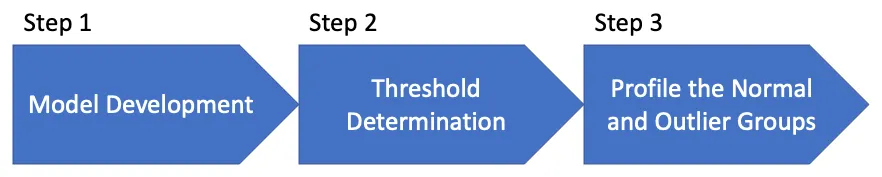



# Libraries, Dataset

In [ ]:
#!pip install plotly
import pandas as pd
import numpy as np
import plotly as plt
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("purchase_credit_card.csv")
df.head(2)

,Year-Month,Agency Number,Agency Name,Cardholder Last Name,Cardholder First Initial,Description,Amount,Vendor,Transaction Date,Posted Date,Merchant Category Code (MCC)
0,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS
1,201307,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,07/30/2013 12:00:00 AM,07/31/2013 12:00:00 AM,SHERATON


In [ ]:
# check dimensions of the dataset, we found it has 442,458 rows and 11 columns
print(df.shape)
print(df.columns) # check column names

(442458, 11)
Index(['Year-Month', 'Agency Number', 'Agency Name', 'Cardholder Last Name',
       'Cardholder First Initial', 'Description', 'Amount', 'Vendor',
       'Transaction Date', 'Posted Date', 'Merchant Category Code (MCC)'],
      dtype='object')


In [ ]:
# change column names
df.columns = ['Year_Month', 'Agency_Number', 'Agency_Name', 'Cardholder_Last_Name',
      'Cardholder_First_Initial', 'Description', 'Amount', 'Vendor', 'Transaction_Date',
      'Posted_Date', 'Merchant_Category']

### Data Cleaning

**Restructring Rationale**

**1.** `Transaction_Date`, `Posted_Date`, `Year_Month`: Manipulate datetime object for them using `.to_datetime()` to enable advanced datetime operations and analysis;

**2.** `Year_Month`: The dataset covers a complete school year from June 2013 to July 2014. To extract the 'month' and 'year' components from the 'Year_Month' column, using the `%Y%m` format and create separate columns for `Year` and `Month`. This allows for more granular analysis and feature engineering based on these temporal aspects;

**3.** `Week_Number`, `DayofWeek`: Derive week-related info from 'Transaction_Date' to incorporate into these two new columns for feature engineering.

**4.** `Amount` is previously a string object. Convert it into float format for performing mathematical calculations and feature engineering.

In [ ]:
# Creating separate Year and Month columns for future feature engineering
# Converting Transaction_Date and Posted_date from Python Object data type to datetime
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])
df['Posted_Date'] = pd.to_datetime(df['Posted_Date'])

df['Year_Month'].dtype
df['Year_Month'] = pd.to_datetime(df['Year_Month'], format='%Y%m')
df['Year'] = df['Year_Month'].dt.year
df['Month'] = df['Year_Month'].dt.month

# Creating 'Week_Number' from 'Transaction_Date'
df['Week_Number'] = df['Transaction_Date'].dt.isocalendar().week

# Reformat Amount column
#df['Amount'] = df['Amount'].str.replace(',', '').astype(float)

### New Dataframe

In [ ]:
# Check the new df columns
df.columns

Index(['Year_Month', 'Agency_Number', 'Agency_Name', 'Cardholder_Last_Name',
       'Cardholder_First_Initial', 'Description', 'Amount', 'Vendor',
       'Transaction_Date', 'Posted_Date', 'Merchant_Category', 'Year', 'Month',
       'Week_Number'],
      dtype='object')

In [ ]:
# Check the datatype of each features
df.dtypes

Year_Month                  datetime64[ns]
Agency_Number                        int64
Agency_Name                         object
Cardholder_Last_Name                object
Cardholder_First_Initial            object
Description                         object
Amount                             float64
Vendor                              object
Transaction_Date            datetime64[ns]
Posted_Date                 datetime64[ns]
Merchant_Category                   object
Year                                 int64
Month                                int64
Week_Number                         UInt32
dtype: object

In [ ]:
df.head(10)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,2013,7,31
1,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,2013-07-30,2013-07-31,SHERATON,2013,7,31
2,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,2013-07-29,2013-07-31,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,2013,7,31
3,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,2013-07-30,2013-07-31,"GROCERY STORES,AND SUPERMARKETS",2013,7,31
4,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,2013-07-30,2013-07-31,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT...",2013,7,31
5,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,GENERAL PURCHASE,394.28,KYOCERA DOCUMENT SOLUTION,2013-07-29,2013-07-31,"OFFICE, PHOTOGRAPHIC, PHOTOCOPY, AND MICROFILM...",2013,7,31
6,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mays,B,GENERAL PURCHASE,19.87,WAL-MART #0137,2013-07-30,2013-07-31,"GROCERY STORES,AND SUPERMARKETS",2013,7,31
7,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mays,B,GENERAL PURCHASE,10.10,DAYLIGHT DONUTS,2013-07-29,2013-07-31,FAST FOOD RESTAURANTS,2013,7,31
8,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,McCarthy,D,GENERAL PURCHASE,142.60,UFIRST LAUNDRY SVCS,2013-07-30,2013-07-31,"MENS, WOMENS AND CHILDRENS UNIFORMS AND COMMER...",2013,7,31
9,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,McClurg,L,AT&T SERVICE PAYMENT ITM,29.99,AT&T DATA,2013-07-30,2013-07-31,TELECOMMUNICATION SERVICES,2013,7,31


In [ ]:
df.tail(10)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number
442448,2014-06-01,98000,GRAND RIVER DAM AUTH.,Cardholder,e,GENERAL PURCHASE,2622.70,HAROLDS AUTO PARTS OF,2014-06-20,2014-06-23,AUTOMOTIVE PARTS AND ACCESSORIES STORES,2014,6,25
442449,2014-06-01,98000,GRAND RIVER DAM AUTH.,Cardholder,e,GENERAL PURCHASE,132790.14,EVANS ENTERPRISES,2014-06-20,2014-06-23,"COMMERCIAL EQUIPMENT, NOT ELSEWHERE CLASSIFIED",2014,6,25
442450,2014-06-01,98000,GRAND RIVER DAM AUTH.,Cardholder,e,GENERAL PURCHASE,1307.58,YELLOWHOUSE MACHINERY CO-,2014-06-19,2014-06-23,"MISC. AUTOMOTIVE,AIRCRAFT,AND FARM EQUIPMENT D...",2014,6,25
442451,2014-06-01,98000,GRAND RIVER DAM AUTH.,Cardholder,e,Payment on Account Each,3302.60,O REILLY AUTO 00050559,2014-06-19,2014-06-23,AUTOMOTIVE PARTS AND ACCESSORIES STORES,2014,6,25
442452,2014-06-01,98000,GRAND RIVER DAM AUTH.,Cardholder,e,FUEL PUMP EA|FUEL PUMP GASKET EA|CLAMP 5 EA|CO...,189.13,WHITE STAR MACHINERY,2014-06-20,2014-06-23,"COMMERCIAL EQUIPMENT, NOT ELSEWHERE CLASSIFIED",2014,6,25
442453,2014-06-01,98000,GRAND RIVER DAM AUTH.,Cardholder,e,GENERAL PURCHASE,992.00,TOTAL VALVE SYSTEMS,2014-06-20,2014-06-23,HARDWARE EQUIPMENT AND SUPPLIES,2014,6,25
442454,2014-06-01,98000,GRAND RIVER DAM AUTH.,Cardholder,e,GENERAL PURCHASE,2415.00,PRYOR WASTE & RECYCLING L,2014-06-20,2014-06-23,"UTILITIES - ELECTRIC,GAS,WATER,SANITARY",2014,6,25
442455,2014-06-01,98000,GRAND RIVER DAM AUTH.,Cardholder,e,GENERAL PURCHASE,177.50,ACCURATE ENVIROMENTAL LAB,2014-06-20,2014-06-23,BUSINESS SERVICES NOT ELSEWHERE CLASSIFIED,2014,6,25
442456,2014-06-01,98000,GRAND RIVER DAM AUTH.,Cardholder,e,GENERAL PURCHASE,32457.00,RED BUD SERVICE INC,2014-06-19,2014-06-23,PROFESSIONAL SERVICES NOT ELSEWHERE CLASSIFIED,2014,6,25
442457,2014-06-01,98000,GRAND RIVER DAM AUTH.,Cardholder,e,GENERAL PURCHASE,4714.07,WARRENCAT CREDIT DEPT,2014-06-20,2014-06-23,MISCELLANEOUS AND SPECIALTY RETAIL STORES,2014,6,25


# Feature Engineering: Revisit & Revise<a class="anchor" id="5"></a>

## Feature 1: Duration between Transaction Date and Posted Date

- Create a new DataFrame 'df1' with the added feature 1 'Transaction_Posted_Duration'

In [ ]:
df1 = df.assign(Transaction_Posted_Duration=(df['Posted_Date'] - df['Transaction_Date']).dt.days)
df1.head(2)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Transaction_Posted_Duration
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,2013,7,31,1
1,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,2013-07-30,2013-07-31,SHERATON,2013,7,31,1


In [ ]:
df['Transaction_Posted_Duration'] = df1['Transaction_Posted_Duration']
df.head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Transaction_Posted_Duration
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,2013,7,31,1
1,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,2013-07-30,2013-07-31,SHERATON,2013,7,31,1
2,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,2013-07-29,2013-07-31,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,2013,7,31,2
3,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,2013-07-30,2013-07-31,"GROCERY STORES,AND SUPERMARKETS",2013,7,31,1
4,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,2013-07-30,2013-07-31,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT...",2013,7,31,1


In [ ]:
df["Transaction_Posted_Duration"].isnull().sum()

0

**Feature 2** and **Feature 3**

are similar. Both focus on analyzing the time gaps between purchases to identify transactions that occur too frequently within a short period of time or transactions that have a significant time gap compared to the previous one. Transactions occurring too frequently within a short period of time might indicate suspicious activity, such as multiple fraudulent purchases made in rapid succession. Conversely, transactions with a significant time gap compared to the previous one could suggest irregularities, such as long delays between legitimate transactions or potentially missed transactions.

Feature 2 examines the time difference between consecutive transactions in days, while Feature 3 examines the time difference in minutes. Therefore, the re-structing of the dataset is almost the same, involving the use of different time units with the `.diff()` function.


## Feature 2: Transaction Records with Long Delay

In [ ]:
# Sort the DataFrame by transaction date in ascending order
df.sort_values(by='Transaction_Date', inplace=False)

# Calculate the time difference between consecutive transaction dates in days
df2 = df.assign(Time_Since_Last_Purchase_by_Day=df['Transaction_Date'].diff().dt.days)

# Replace negative values with NaN
df2.loc[df2['Time_Since_Last_Purchase_by_Day'] < 0, 'Time_Since_Last_Purchase_by_Day'] = np.nan

# Drop rows with NaN values in the 'Time_Since_Last_Purchase_by_Day' column
df2.dropna(subset=['Time_Since_Last_Purchase_by_Day'], inplace=True)

# Print the updated DataFrame
df['Time_Since_Last_Purchase_by_Day'] = df2['Time_Since_Last_Purchase_by_Day']
df.head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Transaction_Posted_Duration,Time_Since_Last_Purchase_by_Day
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,2013,7,31,1,NaN
1,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,2013-07-30,2013-07-31,SHERATON,2013,7,31,1,0.0
2,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,2013-07-29,2013-07-31,DIRCT MARKETING/DIRCT MARKETERS--NOT ELSEWHERE...,2013,7,31,2,NaN
3,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,2013-07-30,2013-07-31,"GROCERY STORES,AND SUPERMARKETS",2013,7,31,1,1.0
4,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,2013-07-30,2013-07-31,"STATIONERY, OFFICE SUPPLIES, PRINTING AND WRIT...",2013,7,31,1,0.0


In [ ]:
df['Time_Since_Last_Purchase_by_Day'].isnull().sum()

106333

In [ ]:
# Replace the null values with 0
df['Time_Since_Last_Purchase_by_Day'].fillna(0, inplace=True)

# Check the number of null values after replacement (should be 0)
df['Time_Since_Last_Purchase_by_Day'].isnull().sum()

0

## Feature 3: Transactions Happened in Quick Succession

In [ ]:
# Sort the DataFrame by transaction date in ascending order
df.sort_values(by='Transaction_Date', inplace=False)

# Calculate the time difference between consecutive transaction dates in days
df3 = df.assign(Time_Since_Last_Purchase_by_Min=df['Transaction_Date'].diff().dt.total_seconds() / 60)

# Replace negative values with NaN
df3.loc[df3['Time_Since_Last_Purchase_by_Min'] < 0, 'Time_Since_Last_Purchase_by_Min'] = np.nan

# Drop rows with NaN values in the 'Time_Since_Last_Purchase_by_Min' column
df3.dropna(subset=['Time_Since_Last_Purchase_by_Min'], inplace=True)

# Print the updated DataFrame
df['Time_Since_Last_Purchase_by_Min'] = df3['Time_Since_Last_Purchase_by_Min']
df.head(2)

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,Merchant_Category,Year,Month,Week_Number,Transaction_Posted_Duration,Time_Since_Last_Purchase_by_Day,Time_Since_Last_Purchase_by_Min
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,CHARITABLE AND SOCIAL SERVICE ORGANIZATIONS,2013,7,31,1,0.0,NaN
1,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,2013-07-30,2013-07-31,SHERATON,2013,7,31,1,0.0,0.0


In [ ]:
# Replace the null values with 0
df['Time_Since_Last_Purchase_by_Min'].fillna(0, inplace=True)

# Check the number of null values after replacement (should be 0)
df['Time_Since_Last_Purchase_by_Min'].isnull().sum()

0

## Encoding for variable "Description"

The following features7,8,9,10,11 are based on the `Description` column. Since it's a categorical variable, firstly, I performed feature hashing on `Description`, resulting in five general features based on the EDA analysis: 'GENERAL PURCHASE', 'AIR TRAVEL', 'ROOM CHARGES', 'ATT', and 'Others'. These features represent the most common types of purchases observed in the dataset, with the 'Others' category capturing the remaining descriptions. The resulting encoded features have been added to the `df_hash` DataFrame.


Actually, when trying to approach this feature, the first thought was using dummy coding, but then it's nothing more than filtering the dataframe. Also, doing one-hot coding for every desciption is impossible for this dataset as there are 88,749 different descriptions. The resulting hashed features ranged from -18.0 to 8.0, which makes it challenging to apply further dummy coding. In such cases, the algorithm automatically categorizes negative values as 0 and positive values as 1, leading to biased results.


Finally, the logic behind creating these features is based on my personal belief that there exists a relationship between anomalies in transaction amounts and specific purchasing purposes indicated by the description. I hypothesize that fraudulent monetary values can vary depending on the nature of the purchase. It's worth capturing any correlation and variation that can help in detecting fradulent activities.

### Feature Hasher

In [ ]:
import pandas as pd
from sklearn.feature_extraction import FeatureHasher

descriptions = df['Description']

# Create a FeatureHasher object with the desired number of hash buckets
hasher = FeatureHasher(n_features=5, input_type='string')

# Perform feature hashing on the descriptions
hashed_features = hasher.transform(descriptions)

# Convert the hashed features to a Pandas DataFrame
hashed_features_df = pd.DataFrame(hashed_features.toarray())

# Rename the columns with meaningful words
hashed_features_df.columns = ['GENERAL PURCHASE', 'AIR TRAVEL', 'ROOM CHARGES', 'ATT', 'Others']

# Concatenate the hashed DataFrame with the original DataFrame
df = pd.concat([df, hashed_features_df], axis=1)

# Print the updated DataFrame with the renamed hashed features
df.head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,...,Month,Week_Number,Transaction_Posted_Duration,Time_Since_Last_Purchase_by_Day,Time_Since_Last_Purchase_by_Min,GENERAL PURCHASE,AIR TRAVEL,ROOM CHARGES,ATT,Others
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,...,7,31,1,0.0,0.0,-1.0,-3.0,5.0,-1.0,4.0
1,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,2013-07-30,2013-07-31,...,7,31,1,0.0,0.0,1.0,-1.0,5.0,-1.0,4.0
2,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,2013-07-29,2013-07-31,...,7,31,2,0.0,0.0,-1.0,-3.0,5.0,-1.0,4.0
3,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,2013-07-30,2013-07-31,...,7,31,1,1.0,1440.0,-1.0,-3.0,5.0,-1.0,4.0
4,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,2013-07-30,2013-07-31,...,7,31,1,0.0,0.0,2.0,-8.0,8.0,-1.0,3.0


- Then I test the correlation between the 5 added features to ensure that all of them can be used for feature engineering. Because if there are strong correlations between some of the added features, it might indicate redundancy or multicollinearity.

### Multicollinearity Detection

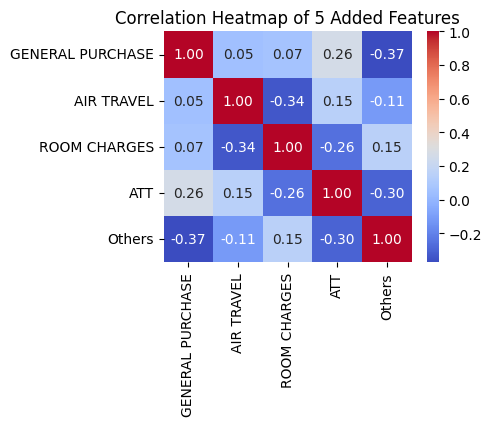

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Subset the DataFrame to include only the added features
added_features = df[['GENERAL PURCHASE', 'AIR TRAVEL', 'ROOM CHARGES', 'ATT', 'Others']]

# Compute the correlation matrix
correlation_matrix = added_features.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of 5 Added Features')
plt.show()

- There is no multicollinearity among the 5 features, so the following five FE analysis can be guided by them.

## Feature 4: Amount Anomalies with Purchasing Purpose 'GENERAL PURCHASE'

## Feature 5: Amount Anomalies with Purchasing Purpose 'AIR TRAVEL'

## Feature 6: Amount Anomalies with Purchasing Purpose 'ROOM CHARGES'

## Feature 7: Amount Anomalies with Purchasing Purpose 'ATT'

## Feature 8: Amount Anomalies with Purchasing Purpose 'Others'

In [ ]:
df.head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,...,Month,Week_Number,Transaction_Posted_Duration,Time_Since_Last_Purchase_by_Day,Time_Since_Last_Purchase_by_Min,GENERAL PURCHASE,AIR TRAVEL,ROOM CHARGES,ATT,Others
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,...,7,31,1,0.0,0.0,-1.0,-3.0,5.0,-1.0,4.0
1,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,2013-07-30,2013-07-31,...,7,31,1,0.0,0.0,1.0,-1.0,5.0,-1.0,4.0
2,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,2013-07-29,2013-07-31,...,7,31,2,0.0,0.0,-1.0,-3.0,5.0,-1.0,4.0
3,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,2013-07-30,2013-07-31,...,7,31,1,1.0,1440.0,-1.0,-3.0,5.0,-1.0,4.0
4,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,2013-07-30,2013-07-31,...,7,31,1,0.0,0.0,2.0,-8.0,8.0,-1.0,3.0


## Feature 9-19: Hashing the 'Vendor' feature

In [ ]:
import pandas as pd
from sklearn.feature_extraction import FeatureHasher

# Assuming you have the DataFrame 'df' with the 'Vendor' column

# Extract the 'Vendor' column for feature hashing
vendor = df['Vendor']

# Create a FeatureHasher object with the desired number of hash buckets
hasher = FeatureHasher(n_features=10, input_type='string')

# Perform feature hashing on the 'Vendor' column
hashed_features = hasher.transform(vendor)

# Convert the hashed features to a Pandas DataFrame
hashed_features_df_vendor = pd.DataFrame(hashed_features.toarray())

# Rename the columns with meaningful words
hashed_features_df_vendor.columns = ['vendor1', 'vendor2', 'vendor3', 'vendor4', 'vendor5', 'vendor6', 'vendor7', 'vendor8', 'vendor9', 'vendor10']

# Concatenate the hashed DataFrame with the original DataFrame
df = pd.concat([df, hashed_features_df_vendor], axis=1)

df.head()

,Year_Month,Agency_Number,Agency_Name,Cardholder_Last_Name,Cardholder_First_Initial,Description,Amount,Vendor,Transaction_Date,Posted_Date,...,vendor1,vendor2,vendor3,vendor4,vendor5,vendor6,vendor7,vendor8,vendor9,vendor10
0,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,GENERAL PURCHASE,890.00,NACAS,2013-07-30,2013-07-31,...,0.0,-1.0,2.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0
1,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mason,C,ROOM CHARGES,368.96,SHERATON HOTEL,2013-07-30,2013-07-31,...,0.0,-3.0,4.0,0.0,0.0,0.0,0.0,1.0,-1.0,3.0
2,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,J,GENERAL PURCHASE,165.82,SEARS.COM 9300,2013-07-29,2013-07-31,...,2.0,0.0,3.0,-1.0,0.0,0.0,0.0,1.0,-2.0,-1.0
3,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Massey,T,GENERAL PURCHASE,96.39,WAL-MART #0137,2013-07-30,2013-07-31,...,2.0,-2.0,3.0,0.0,-1.0,1.0,0.0,-1.0,1.0,-1.0
4,2013-07-01,1000,OKLAHOMA STATE UNIVERSITY,Mauro-Herrera,M,HAMMERMILL COPY PLUS COPY EA,125.96,STAPLES DIRECT,2013-07-30,2013-07-31,...,0.0,-5.0,2.0,0.0,1.0,0.0,1.0,2.0,-2.0,1.0


## Feature 20: Total Amount Spent On The Same Day Up To This Transaction

- Use `.groupby()` and `.cumsum()` to build the feature

In [ ]:
# Sort the DataFrame by the 'Transaction_Date' column in ascending order
df12 = df.sort_values('Transaction_Date')

# Calculate the cumulative sum of the 'Amount' column within each day
df['Total_Amount_Spent_On_The_Same_Day'] = df12.groupby('Transaction_Date')['Amount'].cumsum()

df['Total_Amount_Spent_On_The_Same_Day'].isnull().sum()

0

# New Dataframe
Drop the features 'Transaction_Date', 'Posted_Date', 'Description', 'Vendor', 'Agency_Name','Merchant_Category'

**The fitting models require all of the inputs to be numerical and non-null.**

In [ ]:
df = df.drop(['Year_Month','Merchant_Category','Vendor','Agency_Name','Cardholder_Last_Name','Cardholder_First_Initial','Agency_Number','Transaction_Date', 'Posted_Date', 'Description'], axis=1)
df.head()

,Amount,Year,Month,Week_Number,Transaction_Posted_Duration,Time_Since_Last_Purchase_by_Day,Time_Since_Last_Purchase_by_Min,GENERAL PURCHASE,AIR TRAVEL,ROOM CHARGES,...,vendor2,vendor3,vendor4,vendor5,vendor6,vendor7,vendor8,vendor9,vendor10,Total_Amount_Spent_On_The_Same_Day
0,890.00,2013,7,31,1,0.0,0.0,-1.0,-3.0,5.0,...,-1.0,2.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,461415.84
1,368.96,2013,7,31,1,0.0,0.0,1.0,-1.0,5.0,...,-3.0,4.0,0.0,0.0,0.0,0.0,1.0,-1.0,3.0,586669.62
2,165.82,2013,7,31,2,0.0,0.0,-1.0,-3.0,5.0,...,0.0,3.0,-1.0,0.0,0.0,0.0,1.0,-2.0,-1.0,164358.67
3,96.39,2013,7,31,1,1.0,1440.0,-1.0,-3.0,5.0,...,-2.0,3.0,0.0,-1.0,1.0,0.0,-1.0,1.0,-1.0,586300.66
4,125.96,2013,7,31,1,0.0,0.0,2.0,-8.0,8.0,...,-5.0,2.0,0.0,1.0,0.0,1.0,2.0,-2.0,1.0,585964.27


In [ ]:
df.columns

Index(['Amount', 'Year', 'Month', 'Week_Number', 'Transaction_Posted_Duration',
       'Time_Since_Last_Purchase_by_Day', 'Time_Since_Last_Purchase_by_Min',
       'GENERAL PURCHASE', 'AIR TRAVEL', 'ROOM CHARGES', 'ATT', 'Others',
       'vendor1', 'vendor2', 'vendor3', 'vendor4', 'vendor5', 'vendor6',
       'vendor7', 'vendor8', 'vendor9', 'vendor10',
       'Total_Amount_Spent_On_The_Same_Day'],
      dtype='object')

In [ ]:
df.shape

(442458, 23)

# (A)HBOS

- If an observation is an outlier in terms of almost all variables, the observation is likely an outlier.
- The HBOS defines the outlier score for each variable based on its histogram.
- The outlier scores of all variables can be added up to get the multivariate outlier score for an observation.
- Because histograms are easy to construct, the HBOS is an efficient unsupervised method to detect anomalies.

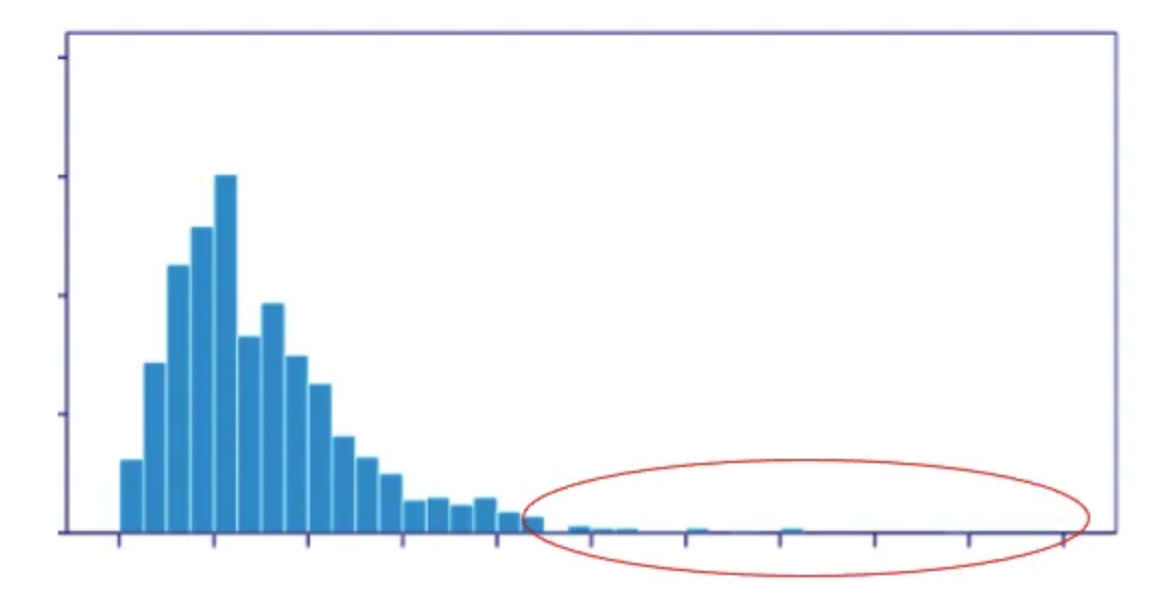

## Libs, Train-Test Split

In [ ]:
#!pip install pyod
#!pip install numpy==1.21
#!pip install --upgrade numba

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pyod.utils.data import generate_data
from pyod.utils.utility import standardizer

# Assuming you have the data 'df' ready

# Split the data into training and test sets using train_test_split
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

# Convert the training and test data to pandas DataFrames
X_train_pd = pd.DataFrame(X_train)
X_test_pd = pd.DataFrame(X_test)

## Build the model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pyod.models.hbos import HBOS
from pyod.utils.data import generate_data

# Create an instance of the HBOS model
hbos_model = HBOS(contamination=0.05)

# Fit the HBOS model on the training data
hbos_model.fit(X_train)

# Generate HBOS scores for the training and test data
y_train_scores = hbos_model.decision_function(X_train)
y_train_pred = hbos_model.predict(X_train)

# Test data
y_test_scores = hbos_model.decision_function(X_test)
y_test_pred = hbos_model.predict(X_test) # outlier labels (0 or 1)

In [ ]:
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("Training data - Outlier Count:", count_stat(y_train_pred))
print("Test data - Outlier Count:", count_stat(y_test_pred))
# Threshold for the defined contamination rate
print("The threshold for the defined contamination rate:", hbos_model.threshold_)

Training data - Outlier Count: {0: 336268, 1: 17698}
Test data - Outlier Count: {0: 83983, 1: 4509}
The threshold for the defined contamination rate: -55.00203894969804


## HBOS outlier scores

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pyod.models.hbos import HBOS

# Assuming you have the data 'X_train' and 'X_test' ready

# Create an instance of the HBOS model
hbos_model = HBOS(n_bins=5000, contamination=0.05)  # Adjust the parameters as needed

# Fit the HBOS model on the training data
hbos_model.fit(X_train)

# Generate HBOS scores for the training and test data
y_train_scores = hbos_model.decision_function(X_train)
y_test_scores = hbos_model.decision_function(X_test)

# The HBOS scores are now stored in 'y_train_scores' and 'y_test_scores'
print("HBOS scores for the training data:")
print(y_train_scores)

print("\nHBOS scores for the test data:")
print(y_test_scores)

HBOS scores for the training data:
[-57.29731863 -43.44350465 -43.16569773 ... -82.06449231 -73.53435765
 -68.92572942]

HBOS scores for the test data:
[-59.46310789 -53.47628532 -47.32297227 ... -68.83401037 -79.96224008
 -57.42022937]


## HBOS Histogram auto bins

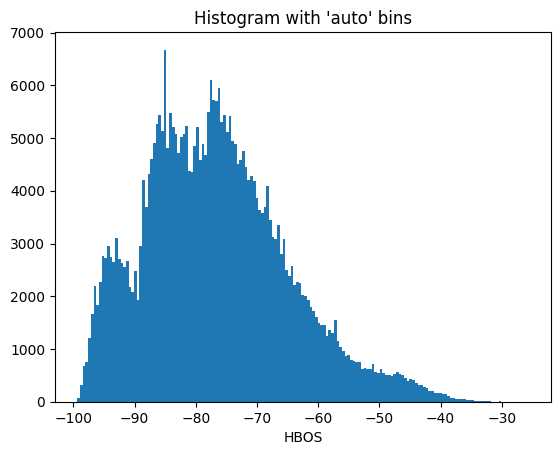

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('HBOS')
plt.show()

## HBOS Threshold

In [ ]:
print("The threshold for the defined comtanimation rate:" , hbos_model.threshold_)

The threshold for the defined comtanimation rate: -55.00203894969804


In [ ]:
threshold = hbos_model.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

## HBOS Descriptive Statistics

In [ ]:
descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,Amount,Year,Month,Week_Number,Transaction_Posted_Duration,Time_Since_Last_Purchase_by_Day,Time_Since_Last_Purchase_by_Min,...,vendor3,vendor4,vendor5,vendor6,vendor7,vendor8,vendor9,vendor10,Total_Amount_Spent_On_The_Same_Day,Anomaly_Score
0,Normal,336267,94.999802,433.47,2013.51,6.38,25.96,1.90,0.55,793.26,...,3.91,-0.16,0.65,0.11,0.35,-0.07,-1.06,1.19,336386.48,-78.07
1,Outlier,17699,5.000198,300.59,2013.51,6.35,25.87,1.46,1.04,1496.95,...,2.33,0.23,-0.12,-0.41,1.28,-0.34,-0.15,0.25,310261.99,-48.44


In [ ]:
descriptive_stat_threshold(X_test,y_test_scores, threshold)

,Group,Count,Count %,Amount,Year,Month,Week_Number,Transaction_Posted_Duration,Time_Since_Last_Purchase_by_Day,Time_Since_Last_Purchase_by_Min,...,vendor3,vendor4,vendor5,vendor6,vendor7,vendor8,vendor9,vendor10,Total_Amount_Spent_On_The_Same_Day,Anomaly_Score
0,Normal,84093,95.028929,424.06,2013.51,6.37,25.89,1.91,0.56,802.6,...,3.90,-0.16,0.66,0.11,0.35,-0.08,-1.07,1.19,338284.98,-78.11
1,Outlier,4399,4.971071,295.14,2013.53,6.31,25.63,1.51,1.01,1454.4,...,2.32,0.25,-0.12,-0.41,1.30,-0.30,-0.14,0.28,308507.41,-48.36


## HBOS Averages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pyod.models.hbos import HBOS
from pyod.utils.utility import standardizer
from pyod.models.combination import aom, moa, average, maximization

# Assuming you have the data 'X_train' and 'X_test' ready

# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)

# Test a range of binning
k_list = [5, 10, 15, 20, 25, 30, 50, 60, 75, 100]
n_clf = len(k_list)
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

# Modeling
for i in range(n_clf):
    k = k_list[i]
    hbos = HBOS(n_bins=k)
    hbos.fit(X_train_norm)
    # Store the results in each column:
    train_scores[:, i] = hbos.decision_function(X_train_norm)
    test_scores[:, i] = hbos.decision_function(X_test_norm)

# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)

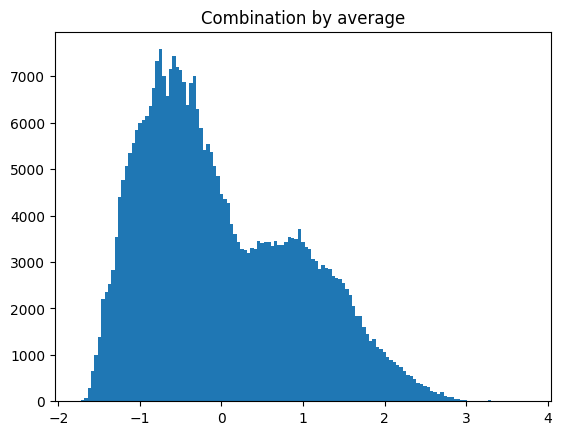

In [ ]:
# Combination by average
# The test_scores_norm is 500 x 10. The "average" function will take the average of the 10 columns. The result "y_by_average" is a single column:
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_train_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [ ]:
descriptive_stat_threshold(X_train,y_train_by_average, 1.4)

,Group,Count,Count %,Amount,Year,Month,Week_Number,Transaction_Posted_Duration,Time_Since_Last_Purchase_by_Day,Time_Since_Last_Purchase_by_Min,...,vendor3,vendor4,vendor5,vendor6,vendor7,vendor8,vendor9,vendor10,Total_Amount_Spent_On_The_Same_Day,Anomaly_Score
0,Normal,317958,89.827272,438.87,2013.51,6.37,25.92,1.87,0.54,779.27,...,3.92,-0.11,0.63,0.11,0.35,-0.06,-1.13,1.34,331823.73,-0.21
1,Outlier,36008,10.172728,320.50,2013.49,6.46,26.28,1.87,0.88,1262.68,...,2.99,-0.45,0.47,-0.15,0.89,-0.35,-0.04,-0.57,363835.52,1.82


In [ ]:
descriptive_stat_threshold(X_test,y_test_by_average, 1.4)

,Group,Count,Count %,Amount,Year,Month,Week_Number,Transaction_Posted_Duration,Time_Since_Last_Purchase_by_Day,Time_Since_Last_Purchase_by_Min,...,vendor3,vendor4,vendor5,vendor6,vendor7,vendor8,vendor9,vendor10,Total_Amount_Spent_On_The_Same_Day,Anomaly_Score
0,Normal,79416,89.743706,428.29,2013.51,6.36,25.85,1.88,0.55,790.19,...,3.92,-0.11,0.64,0.11,0.35,-0.06,-1.14,1.35,333734.43,-0.21
1,Outlier,9076,10.256294,324.51,2013.50,6.42,26.09,1.90,0.85,1227.08,...,2.98,-0.44,0.49,-0.14,0.88,-0.37,-0.00,-0.58,363670.04,1.81


# (B)ECODs
The Empirical Cumulative Distribution-based Outlier Detection (ECOD) has a very intuitive approach: Outliers are the rare events in the tails of a distribution, they can be identified by measuring the location in a distribution.

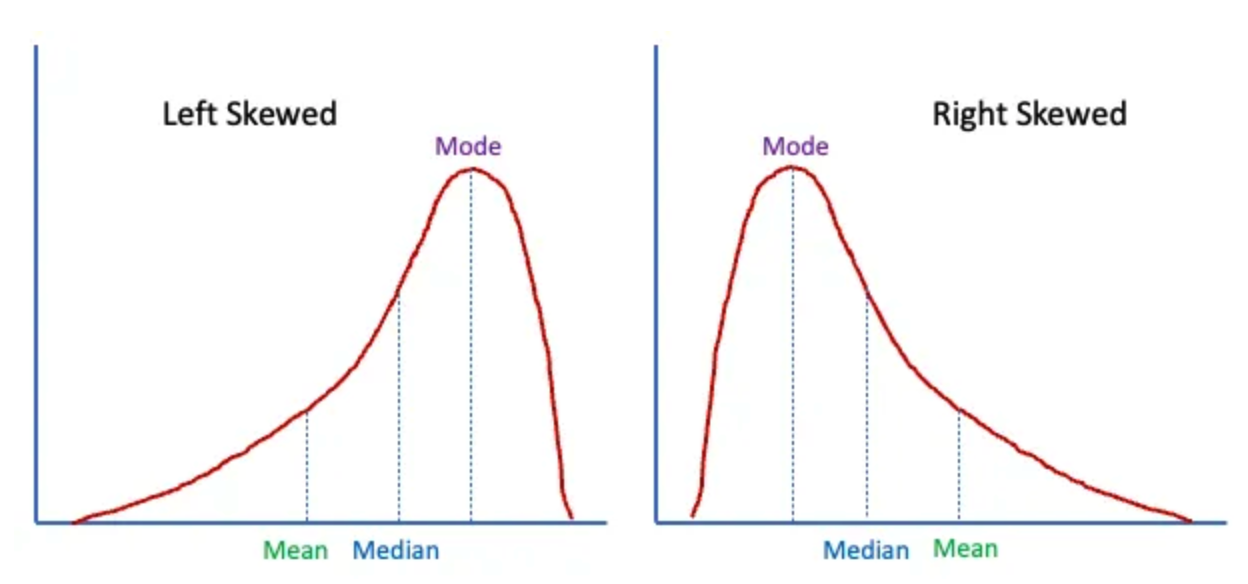

## Train-test split

In [ ]:
# Split the data into training and test sets using train_test_split
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

# Convert the training and test data to pandas DataFrames
X_train_pd = pd.DataFrame(X_train)
X_test_pd = pd.DataFrame(X_test)

## Build the model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pyod.models.ecod import ECOD
from pyod.utils.data import generate_data
from pyod.utils.utility import standardizer

# Assuming you have the data 'X_train' and 'X_test' ready

# Standardize the data
X_train_norm, X_test_norm = standardizer(X_train, X_test)

# Create an instance of the ECOD model with contamination rate of 0.05
ecod = ECOD(contamination=0.05)

# Fit the ECOD model on the training data
ecod.fit(X_train_norm)

# Generate ECOD scores for the training and test data
y_train_scores = ecod.decision_function(X_train_norm)
y_train_pred = ecod.predict(X_train_norm)

# Test data
y_test_scores = ecod.decision_function(X_test_norm)
y_test_pred = ecod.predict(X_test_norm) # outlier labels (0 or 1)

## ECOD Threshold

In [ ]:
def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic.
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("Count statistics for the training data:", count_stat(y_train_pred))
print("Count statistics for the test data:", count_stat(y_test_pred))

print("The threshold for the defined contamination rate:", ecod.threshold_)

Count statistics for the training data: {0: 336267, 1: 17699}
Count statistics for the test data: {0: 84000, 1: 4492}
The threshold for the defined contamination rate: 38.06276326608999


## ECOD outlier score

In [ ]:
np.where(y_train_scores>40)

(array([     0,      1,      2, ..., 353942, 353943, 353957]),)

## ECOD built-in explaination

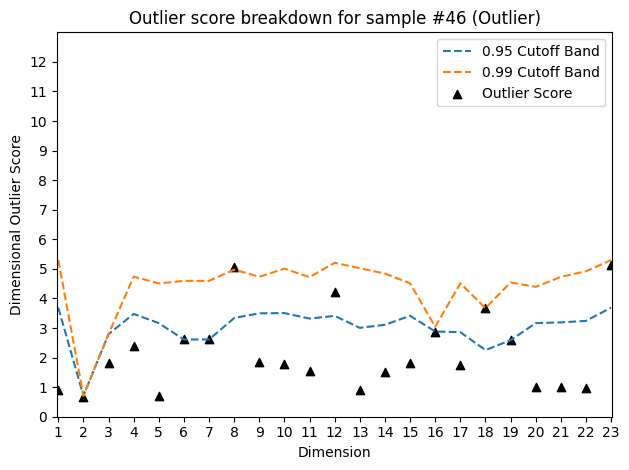

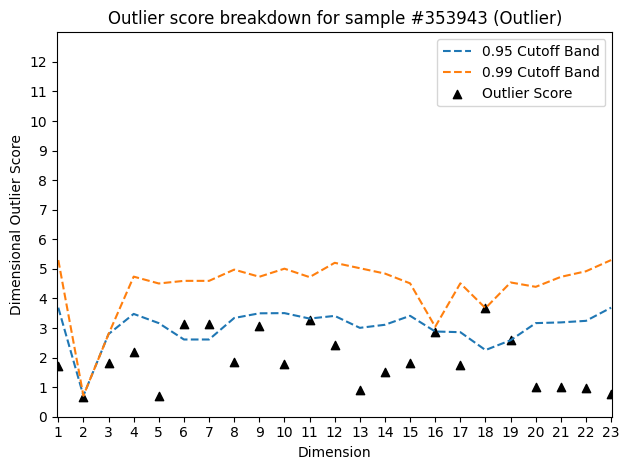

In [ ]:
ecod.explain_outlier(45)
ecod.explain_outlier(353942)

## ECOD Histogram auto bins

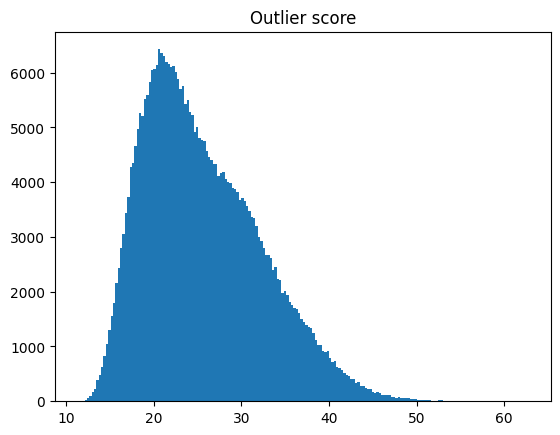

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto') # arguments are passed to np.histogram
plt.title("Outlier score")
plt.show()

## ECOD Descriptive Statistics

In [ ]:
threshold = ecod.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,Amount,Year,Month,Week_Number,Transaction_Posted_Duration,Time_Since_Last_Purchase_by_Day,Time_Since_Last_Purchase_by_Min,...,vendor3,vendor4,vendor5,vendor6,vendor7,vendor8,vendor9,vendor10,Total_Amount_Spent_On_The_Same_Day,Anomaly_Score
0,Normal,336267,94.999802,413.50,2013.51,6.37,25.93,1.89,0.48,689.36,...,3.89,-0.14,0.64,0.10,0.37,-0.08,-1.05,1.21,336281.27,24.80
1,Outlier,17699,5.000198,680.04,2013.49,6.52,26.54,1.67,2.41,3471.00,...,2.57,-0.12,0.22,-0.22,0.98,-0.19,-0.42,-0.11,312260.91,41.32


In [ ]:
descriptive_stat_threshold(X_test,y_test_scores, threshold)

,Group,Count,Count %,Amount,Year,Month,Week_Number,Transaction_Posted_Duration,Time_Since_Last_Purchase_by_Day,Time_Since_Last_Purchase_by_Min,...,vendor3,vendor4,vendor5,vendor6,vendor7,vendor8,vendor9,vendor10,Total_Amount_Spent_On_The_Same_Day,Anomaly_Score
0,Normal,84000,94.923835,411.50,2013.51,6.36,25.86,1.89,0.48,694.85,...,3.89,-0.14,0.65,0.10,0.37,-0.08,-1.05,1.22,338678.74,24.80
1,Outlier,4492,5.076165,532.57,2013.50,6.45,26.18,1.72,2.40,3455.74,...,2.55,-0.13,0.22,-0.21,0.97,-0.22,-0.41,-0.13,301760.61,41.25
